# Intent Recognition In Chatbot System

In this assignment, you will be building machine learning models that can recognize intents of user inputs in chatbot systems. You probably have heard about chatbots before, but for those of you who are not familiar with chatbots, here is a quick description. A chatbot is a program that conducts a conversation via auditory or textual methods. In practice chatbots are used in many different purposes including customer services or information acquisition. Today, most chatbots are accessed via virtual assistants such as Google Assistant, Apple Siri, Amazon Alexa, via messaging apps such as Facebook Messenger, or via individual organization’ apps and websites (you can check out Wikipedia article for more information https://en.wikipedia.org/wiki/Chatbot). You are probably wondering what is intent recognition in chatbot systems? Many chatbot systems that contains the intent recognition module which is trying to figuring out what the users want when interacting with the chatbot. For example, an user might say “find restaurants near me”, “find Vietnamese restaurants near me” which all have the “find_restaurant” intent. Usually, a goal-oriented chatbot has a pre-defined set of intents (goal-oriented chatbot is a type of chatbot that helps users do a specific task like set an alarm, find restaurnts, order pizza, …). For example, an virtual assistants might contains the following intents: set_alarm, find_restaurants, open_app, find_video, … So, the purpose of this assignment is trying to find the intent of a user input using this dataset https://github.com/snipsco/nlu-benchmark/tree/master/2017-06-custom-intent-engines. You can treat this problem as a classification problem which classifies a user input text into a category which is an intent. So, in this assignment you will do the following:
<br>
- Identifying the problem
- Learning about machine learning project life cycle and apply it
- Collecting the data
- Preprocessing the data
- Understanding the data
- Represent user texts as vectors using TfidfVectorizer
- Train, evaluate baseline Logistic Regression model
- Train, evaluate cross-validation Logistic Regression model
- Learning about word embeddings
- Represent user texts as vectors using word embedding with spaCy
- Train, evaluate Feedforward Neural Network model
- Error analysis
- Improving the models
- Deploy the models

## Identifying the problem and machine learning project life cycle
As we have discussed in the previous section, we can view this problem as a machine learning classification problem so you could immediately think, ah let's choose a classification machine learing algorithm and implement it and see the results and then improve it. That process is ok and in fact that is what we are going to do :D, but we will do it more strategically. Before we jump right into the problem let's take a step back and talk about the life cycle of a machine learning project from this book **Machine Learning Yearning** (you can get it for free from the official website https://www.deeplearning.ai/machine-learning-yearning/), so we can apply it to any machine learing project, we highly encourage you to read this book so you can get more details about developing machine projects. The image below is taken from the section 10 from the book that describes a general process when developing a machine learning project.

<img src="images/ml_process.png">

Here is the description that are copied directly from the book:
<br>
1. Start off with some idea on how to build the system.
2. Implement the idea in code.
3. Carry out an experiment which tells me how well the idea worked. (Usually my first few
ideas don’t work!) Based on these learnings, go back to generate more ideas, and keep on
iterating.
<br>

This is an iterative process. The faster you can go round this loop, the faster you will make
progress. The step 3 usually involves evaluating the models using some metrics on the dev set and doing error analysis so we can improve the models. Here we mention the **dev** set in which you might not have heard of it throughout this specification. The book' main focus is on deep learning projects (but we can use for general machine learning projects as well as mention in the book) and often when doing deep learning project, we have quite a lot of data so people usually split the data into three data sets which are train, dev, test; then we iterate and experiment our methods on the dev set, then we choose the best model using the dev set, then evaluate the best model on the test set only once. The reason we don't experiment with our methods on the test set because we might highly end up overfitting the test set, so we only evaluate the test set once to get our final result is a reasonable way to check our model's generation ability.
<br>
In the case we don't have much data we can use cross-validation to tune, experiment with our methods then we pick the best model to evaluate on the test set (we have discussed cross-validation in the **Machine learning classification** course).
<br>
In previous courses in this specification, the process you doing the assignments is some what similar to this process. In this course we will do our assignments using this process and you shold use this process when you do your final project. Now, let's jump into our problem.

## Collecting and preprocessing the data

We will use this data set https://github.com/snipsco/nlu-benchmark/tree/master/2017-06-custom-intent-engines. The data is originally collected as a benchmark for chatbot creating frameworks, services such as Wit.ai, Luis.ai, Api.ai (dialogfow.com now), Alexa, Snips. Those frameworks are really user-friendly and intuitive to use so we highly encourage you to check them out. Those frameworks usually contain intents classification and other features, here we only focus on the intent classification feature and we will implement it our self.
<br>
We have already included the data in the **data** folder for you and only keep the files that we need for this assignment.
<br>
Each folder includes data for the intent and inside each of them contains two JSON files, one for training and one for testing.

### Import some libs

In [1]:
import numpy as np
import sys
import os
import json
import pandas as pd
from sklearn.utils import shuffle

### Read json files
Run the cell below to load the JSON data into **train_df** and **test_df** dataframes. The dataframes have two columns which are **text** (the user input text), **intent** (the intent of the user input text).

In [2]:
def get_json_examples(intent_name, json_data):
    examples = []
    for e in json_data:
        parts = []
        for p in e["data"]:
            parts.append(p["text"])
        examples.append({
            "intent": intent_name,
            "text": "".join(parts)
        })
    return examples

train_json_examples = []
test_json_examples = []

for intent_name in next(os.walk("./data"))[1]:
    train_file = f"data/{intent_name}/train_{intent_name}_full.json"
    test_file = f"data/{intent_name}/validate_{intent_name}.json"

    with open(train_file, "r", encoding="utf8") as f:
        train_json = json.load(f)
        train_json_examples += get_json_examples(intent_name, train_json[intent_name])
        
    with open(test_file, "r", encoding="utf8") as f:
        test_json = json.load(f)
        test_json_examples += get_json_examples(intent_name, test_json[intent_name])
        
train_df = pd.DataFrame.from_records(train_json_examples)
test_df = pd.DataFrame.from_records(test_json_examples)

train_df = shuffle(train_df, random_state=10)
test_df = shuffle(test_df, random_state=10)

In [3]:
train_df.head()

,intent,text
12353,SearchScreeningEvent,movie schedule at Speakeasy Theaters
10554,SearchCreativeWork,I want to watch Escape the Fate discography
12414,SearchScreeningEvent,when is Our Story showing next at North Americ...
11545,SearchCreativeWork,find a picture called How Much Wood Would a Wo...
8313,RateBook,Can you give this textbook a 2 out of 6?


### Plot bar graphs

Plot a bar graph to count the number of texts for each intent in the **train_df**.

In [4]:
train_df['intent'].value_counts()

GetWeather              2000
PlayMusic               2000
BookRestaurant          1973
SearchScreeningEvent    1959
RateBook                1956
SearchCreativeWork      1954
AddToPlaylist           1942
Name: intent, dtype: int64

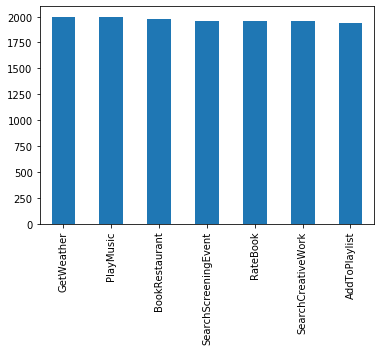

In [5]:
# YOUR CODE HERE
(train_df['intent'].value_counts()).plot.bar()

Plot a bar graph to count the number of texts for each intent in the **test_df**.

In [6]:
test_df['intent'].value_counts()

GetWeather              100
AddToPlaylist           100
RateBook                100
PlayMusic               100
BookRestaurant          100
SearchScreeningEvent    100
SearchCreativeWork      100
Name: intent, dtype: int64

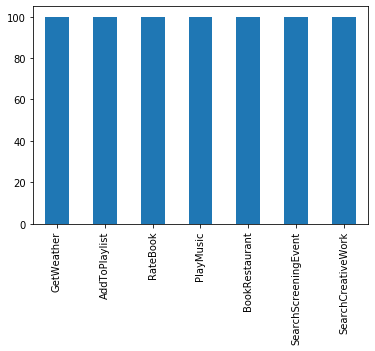

In [7]:
# YOUR CODE HERE
(test_df['intent'].value_counts()).plot.bar()

**Quizz**: Is the train set balanced or imbalanced?
<br>
**Your answer**:

### Look at the data
Now let's look at a few examples in the data to get a sense of what the data is about.

Print the first 30 examples in the **train_df**

In [8]:
# YOUR CODE HERE
train_df.head(30)

,intent,text
12353,SearchScreeningEvent,movie schedule at Speakeasy Theaters
10554,SearchCreativeWork,I want to watch Escape the Fate discography
12414,SearchScreeningEvent,when is Our Story showing next at North Americ...
11545,SearchCreativeWork,find a picture called How Much Wood Would a Wo...
8313,RateBook,Can you give this textbook a 2 out of 6?
2999,BookRestaurant,I want to take four friends to the pub for som...
9118,RateBook,give 5 stars to this book
1231,AddToPlaylist,add the song to my the funny thing about footb...
1574,AddToPlaylist,Add Falling Stars to my Intense Studying
4361,GetWeather,is it going to blizzard at my current position


Print the first 20 examples in the **test_df**

In [9]:
# YOUR CODE HERE
test_df.head(20)

,intent,text
27,AddToPlaylist,add this track to my Hands Up playlist
641,SearchScreeningEvent,what are the movie schedules in the neighborhood
152,BookRestaurant,Book me a table for 5 this year at Cherwell Bo...
302,PlayMusic,Play the newest melody on Last Fm by Eddie Vin...
541,SearchCreativeWork,Could you find the TV series The Approach
518,SearchCreativeWork,Please look up the TV series Parables for Wood...
351,PlayMusic,Play music from E-type.
191,BookRestaurant,book a party of five at Seagoville for 06:42
171,BookRestaurant,Book a reservation for five people for a tatar...
173,BookRestaurant,Book a reservation for ten at a restaurant in ...


### Preprocess the data
Complete the cell below to preprocess the texts. Lower case the texts and remove punctuations from the texts.
<br>
You should use the **translator** variable

In [10]:
import string

translator = str.maketrans('', '', string.punctuation)

def pre_process(text):
    """
        :param text: A user input text
        :return: The preprocessed text
    """
    # YOUR CODE HERE
    return (text.lower()).translate(translator)

train_df["text"] = train_df["text"].apply(pre_process)
test_df["text"] = test_df["text"].apply(pre_process)

Let's have a quick look at our texts again.

In [11]:
train_df.head()

,intent,text
12353,SearchScreeningEvent,movie schedule at speakeasy theaters
10554,SearchCreativeWork,i want to watch escape the fate discography
12414,SearchScreeningEvent,when is our story showing next at north americ...
11545,SearchCreativeWork,find a picture called how much wood would a wo...
8313,RateBook,can you give this textbook a 2 out of 6


In [12]:
test_df.head()

,intent,text
27,AddToPlaylist,add this track to my hands up playlist
641,SearchScreeningEvent,what are the movie schedules in the neighborhood
152,BookRestaurant,book me a table for 5 this year at cherwell bo...
302,PlayMusic,play the newest melody on last fm by eddie vinson
541,SearchCreativeWork,could you find the tv series the approach


## Choosing the model
There is no right way to choose the perfect model for a machine learning problem. We have to try them out to see what is the best fit for our problems. As we have discussed in previous sections, the faster you try the better you make progress. Because this is a text classification problem, so let's use our experience with text classification problems. First, we will try out a simple **Logistic Regression** model with **tfidf** as a baseline and then use **cross-validation** to see if we can improve our model. After that, we will try **Feed Forward Neural Network** with **word embedding** to see what happens. We will introduce **word embedding** in later sections for now just think of **word embedding** is a way to represent texts as vectors for training with **Neural Network** more easily.

## Logistic Regression with tfidf
At this point, you are probably confident with sklearn so, in this section, we just outline some steps and give you some tips then you write all the code yourself.

### Import libs that you need here

In [13]:
# Import libs here
# YOUR CODE HERE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

### Train tfidf vectorizer and transform texts to vectors
You should pay attention to the **ngram_range** parameter when you create the vectorizer.

In [14]:
# YOUR CODE HERE
# Create the vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
# fit and transform the train data
train_matrix = vectorizer.fit_transform(train_df['text'])
# transform the test data
test_matrix = vectorizer.transform(test_df['text'])

### Create and train the model
You should pay attention to the **multi_class**, **solver**, **max_iter** parameters.

In [15]:
# YOUR CODE HERE
# Create and train the model here
model = LogisticRegression(max_iter=1000)
model.fit(train_matrix, train_df['intent'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Evaluate the model
We use **f1** for this problem. For convenience, you should use the **classification_report** from sklearn.
<br>
YOU MUST output precision, recall, f1 for each class and overall for all classes.

In [16]:
# YOUR CODE HERE
# Evaluate your model here
from sklearn.metrics import classification_report

y_true = test_df['intent']
y_pred = model.predict(test_matrix)
print(classification_report(y_true, y_pred))

                      precision    recall  f1-score   support

       AddToPlaylist       0.98      1.00      0.99       100
      BookRestaurant       0.98      1.00      0.99       100
          GetWeather       0.99      0.96      0.97       100
           PlayMusic       1.00      0.97      0.98       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.93      0.99      0.96       100
SearchScreeningEvent       0.97      0.93      0.95       100

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



If you have implemented correctly, you should get about **0.98** f1 score. It is really high though :)).

## Cross-validation with Logistic Regression
Let's tune some parameters using cross-validation to see if we can get any better. You should tune the **C** parameter.

### Create and train the model
You should use the **GridSearchCV** from sklearn.

In [17]:
# YOUR CODE HERE
# Create the model
from sklearn.model_selection import GridSearchCV

model_search = LogisticRegression(max_iter=1000)
# Create tuning parameters
tuning_parameters = {'C': [0.01, 0.05, 0.5, 0.8, 1, 1.2, 1.4, 2, 5, 10]}
# Create GridSearchCV
clf = GridSearchCV(model_search, tuning_parameters)
# Train the model
clf.fit(train_matrix, train_df['intent'])

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.5, 0.8, 1, 1.2, 1.4, 2, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Evaluate the model

In [18]:
# YOUR CODE HERE
# Evaluate the model
y_true = test_df['intent']
y_pred = clf.predict(test_matrix)
print(classification_report(y_true, y_pred))

                      precision    recall  f1-score   support

       AddToPlaylist       0.98      1.00      0.99       100
      BookRestaurant       0.99      1.00      1.00       100
          GetWeather       0.99      0.97      0.98       100
           PlayMusic       1.00      0.97      0.98       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.93      1.00      0.97       100
SearchScreeningEvent       0.98      0.93      0.95       100

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



You should get around **0.98** f1 score. Our baseline Logistic Regression is pretty good though so, with that, we can say that our dataset is well separated.

## Word embedding and Neural Network
In this section we will use **word embedding** to represent user input texts as vectors then we will use **Neural Network** to train our classification model. You might ask, what are **word embeddings** exactly? Loosely speaking, they are vector representations of a particular word. But, why do we need them and can we just use **tfidf** to represent texts as vectors? Well, one disadvantage of **tfidf** or **bag of word** is that the feature dimension could be really large and sparse (sparse in the context of vector mean vectors with a lot of zero values). For our problem, the feature dimension size is **48769** (for ngram_range=(1,2)), meanwhile, we only have **13784** examples and the dimension size increases when the vocabulary size increases. That is very inefficient when training with **Neural Network** in terms of computation. When we use **word embedding**, the vector size is fixed no matter the vocabulary size and in practice, the vector size is usually around 100 - 300. Another advantage of **word embedding** is that it is capable of capturing the context of a word in a document, semantic and syntactic similarity, relation with other words. But, how do we generate them? There are many algorithms can be used for producing **word embedding** like **Word2vec**, **Glove**, **Fasttext**, .... They all are unsupervised machine learning algorithms that are usually trained on really large text corpora. Learning how those algorithms work is beyond the scope of this course. All you should care about now is that some people have already trained those **word embedding** algorithms on very large text corpora, they produce us a lookup table that maps a word to a vector. In practice, the lookup table usually contains millions of words or even billion of words. We will use those pre-trained **word embedding** models in later sections to represent our words as vectors and then use those vectors to feed into our **Neural Network** model.

### Using spaCy for word embedding
We will use spaCy (https://spacy.io/) which is a python library for solving **Natural Language Process (NLP)** tasks more easily. spaCy offers a lot of features but we only use the pre-trained word vectors feature to look up the embedding vector for an English word. First, run the cell below to download the **en_core_web_lg** model for spaCy (you only need to download it once). The **en_core_web_lg** model from spaCy (https://spacy.io/models/en#en_core_web_lg) contains many English models for different tasks. It includes a pre-trained **Glove** word embedding model which has 685k keys, 685k unique vectors (300 dimensions).

In [19]:
# On Windows, remember to run Anaconda prompt with Administrator to make sure this command works probably
# !python -m spacy download en_core_web_lg

### Import spaCy model
Run the cell below to load the **en_core_web_lg** model from spaCy

**NOTE:** If you have trouble loading the **en_core_web_lg** model on Google colab. Please check this question [Unable to load the spacy model 'en_core_web_lg' on Google colab](https://stackoverflow.com/questions/56927602/unable-to-load-the-spacy-model-en-core-web-lg-on-google-colab) on stackoverflow.

In [20]:
import spacy

nlp = spacy.load("en_core_web_lg")

### Word embedding examples
The example below shows you how to get the embedding vector for the word **cat**.

In [21]:
nlp("cat").vector

array([-0.15067  , -0.024468 , -0.23368  , -0.23378  , -0.18382  ,
        0.32711  , -0.22084  , -0.28777  ,  0.12759  ,  1.1656   ,
       -0.64163  , -0.098455 , -0.62397  ,  0.010431 , -0.25653  ,
        0.31799  ,  0.037779 ,  1.1904   , -0.17714  , -0.2595   ,
       -0.31461  ,  0.038825 , -0.15713  , -0.13484  ,  0.36936  ,
       -0.30562  , -0.40619  , -0.38965  ,  0.3686   ,  0.013963 ,
       -0.6895   ,  0.004066 , -0.1367   ,  0.32564  ,  0.24688  ,
       -0.14011  ,  0.53889  , -0.80441  , -0.1777   , -0.12922  ,
        0.16303  ,  0.14917  , -0.068429 , -0.33922  ,  0.18495  ,
       -0.082544 , -0.46892  ,  0.39581  , -0.13742  , -0.35132  ,
        0.22223  , -0.144    , -0.048287 ,  0.3379   , -0.31916  ,
        0.20526  ,  0.098624 , -0.23877  ,  0.045338 ,  0.43941  ,
        0.030385 , -0.013821 , -0.093273 , -0.18178  ,  0.19438  ,
       -0.3782   ,  0.70144  ,  0.16236  ,  0.0059111,  0.024898 ,
       -0.13613  , -0.11425  , -0.31598  , -0.14209  ,  0.0281

A nice property of word embedding is that similar words (words appear in the same contexts) are usually grouped together. For example, the words **good** and **great** are often used in the same context (Have a **great** day, Have a **good** day) so, their embedding vectors are closed to each other than let's say **good** and **cat**. We can use cosine similarity to check the similarity between two vectors, spaCy already has the similarity function so, let's check it out.

In [22]:
print(nlp("great").similarity(nlp("good")))
print(nlp("great").similarity(nlp("cat")))

0.841670781054402
0.2433478967733492


As you can see the similarity between **great** and **good** is **0.84** meanwhile, the similarity between **great** and **cat** is only **0.24** so, you can feel that word embedding somehow can capture the semantics of words. We encourage you to play around with different words.

In [23]:
# Try here
print(nlp("terrible").similarity(nlp("bad")))
print(nlp("pet").similarity(nlp("cat")))
print(nlp("human").similarity(nlp("person")))

0.7739192403324098
0.7505455881628591
0.47039188877751464


### Use word embbedding to represent texts as vectors
We now can represent a single word as vector using word embedding but, how do we represent a sentence or paragraph as a vector so we can feed into our **Feedforward Neural Network**? A simple solution is that you can simply average the word embedding vectors of words in a paragraph to represent that paragraph. People also develop algorithms like **Doc2vec**, **Sent2vec**, ... to represent paragraphs as vectors but, that topic is beyond the scope of this course and in this section, we just use the averaging approach.
<br>
Complete the **average_vectors_text** function below to calculate the average vector representation for a user input text.
<br>
**Note**: Split the text using the space character to get the words.

In [24]:
def average_vectors_text(text):
    """
        :param text: A user input text
        :return: The average vector of word embedding vectors in the text input
    """
    # YOUR CODE HERE
    words = np.array([nlp(i).vector for i in text.split()])
    return np.mean(words, axis=0)

Apply the **average_vectors_text** function to the **text** columns of the **train_df** and **test_df** data frames to get **X_train_spacy** and **X_test_spacy**. The feature dimension size is now only 300.
<br>
**NOTE**: It might takes 15 - 20 minutes to run 

In [25]:
X_train_spacy = train_df["text"].apply(average_vectors_text)
X_test_spacy = test_df["text"].apply(average_vectors_text)

X_train_spacy = X_train_spacy.tolist()
X_test_spacy = X_test_spacy.tolist()

### Create and train the model
Now create a **MLPClassifier** and train it on the **X_train_spacy** and **y_train**.
<br>
**NOTE**: You have to pick the parameters by yourself.

In [26]:
# YOUR CODE HERE
# Create and train the neural network model
from sklearn.neural_network import MLPClassifier

clf_nn = MLPClassifier(random_state=1, max_iter=300)
clf_nn.fit(X_train_spacy, train_df['intent'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### Evaluate the model
Evaluate on the model on the **X_test_spacy** and **y_test**.
<br>

In [27]:
# YOUR CODE HERE
# Evaluate the model
y_true = test_df['intent']
y_pred = clf_nn.predict(X_test_spacy)
print(classification_report(y_true, y_pred))

                      precision    recall  f1-score   support

       AddToPlaylist       0.96      1.00      0.98       100
      BookRestaurant       0.99      0.99      0.99       100
          GetWeather       0.99      0.99      0.99       100
           PlayMusic       1.00      0.96      0.98       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.97      0.96      0.96       100
SearchScreeningEvent       0.96      0.97      0.97       100

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



If you have implemented correctly you should get around **0.98** f1 score.

## Error analysis
Let's look at some of the examples that the models make mistakes to see if we can improve the models.
<br>
Complete the **print_mistake_samples** function below.

In [28]:
def print_mistake_samples(y, y_pred, df):
    """ 
        :param y: The true labels
        :param y_pred: The predicted labels
        :param df: The dataframe (train_df/test_df)
        
        :return: None
    """
    wrong_indices = (y != y_pred)  # YOUR CODE HERE
    wrong_df = df.loc[wrong_indices, :].copy()
    wrong_df["pred"] = y_pred[wrong_indices]
    
    print (f"Number of mistakes: {wrong_df.shape[0]}")
    print ('text, true, predict')
    for i, row in wrong_df.iterrows():
        print(f"{row['text']}, {row['intent']}, {row['pred']}")

Print the mistakes by the simple Logistic Regression model

In [29]:
# YOUR CODE HERE
y_true = test_df['intent']
y_pred = model.predict(test_matrix)
print_mistake_samples(y_true, y_pred, test_df)

Number of mistakes: 15
text, true, predict
where is belgium located, GetWeather, SearchScreeningEvent
overcast on state holiday in pawling nature reserve  and neighboring places, GetWeather, BookRestaurant
humidity not far from colorado city on november the 7th 2024, GetWeather, BookRestaurant
i want to see medal for the general, SearchScreeningEvent, SearchCreativeWork
can you put on like a hurricane by paul landers, PlayMusic, AddToPlaylist
when is sunrise for ar, GetWeather, SearchScreeningEvent
put what color is your sky by alana davis on the stereo, PlayMusic, AddToPlaylist
i want to see jla adventures trapped in time, SearchScreeningEvent, SearchCreativeWork
i want to see those kids from town when will it be showing, SearchScreeningEvent, GetWeather
i want to see shattered image, SearchScreeningEvent, SearchCreativeWork
i want to see fear chamber, SearchScreeningEvent, SearchCreativeWork
where can i see the prime ministers the pioneers, SearchScreeningEvent, SearchCreativeWork
fi

Print the mistakes by the cross-validation Logistic Regression model

In [30]:
# YOUR CODE HERE
y_true = test_df['intent']
y_pred = clf.predict(test_matrix)
print_mistake_samples(y_true, y_pred, test_df)

Number of mistakes: 13
text, true, predict
where is belgium located, GetWeather, SearchScreeningEvent
humidity not far from colorado city on november the 7th 2024, GetWeather, BookRestaurant
i want to see medal for the general, SearchScreeningEvent, SearchCreativeWork
can you put on like a hurricane by paul landers, PlayMusic, AddToPlaylist
when is sunrise for ar, GetWeather, SearchScreeningEvent
put what color is your sky by alana davis on the stereo, PlayMusic, AddToPlaylist
i want to see jla adventures trapped in time, SearchScreeningEvent, SearchCreativeWork
i want to see those kids from town when will it be showing, SearchScreeningEvent, GetWeather
i want to see shattered image, SearchScreeningEvent, SearchCreativeWork
i want to see fear chamber, SearchScreeningEvent, SearchCreativeWork
where can i see the prime ministers the pioneers, SearchScreeningEvent, SearchCreativeWork
i want to see outcast, SearchScreeningEvent, SearchCreativeWork
live in lajoseph meyer please, PlayMusic, 

Print the mistakes by the Neural Network model

In [31]:
# YOUR CODE HERE
y_true = test_df['intent']
y_pred = clf_nn.predict(X_test_spacy)
print_mistake_samples(y_true, y_pred, test_df)

Number of mistakes: 13
text, true, predict
please fine me the tv series now we are married, SearchCreativeWork, SearchScreeningEvent
please look up and find me monty python live at the hollywood bowl, SearchCreativeWork, SearchScreeningEvent
can you put on like a hurricane by paul landers, PlayMusic, AddToPlaylist
play my black sabbath the dio years playlist, PlayMusic, AddToPlaylist
when is sunrise for ar, GetWeather, SearchScreeningEvent
i want to book oregon electric station in north city, BookRestaurant, GetWeather
im looking for welcome to the canteen, SearchCreativeWork, BookRestaurant
i want to see shattered image, SearchScreeningEvent, SearchCreativeWork
i want to see outcast, SearchScreeningEvent, SearchCreativeWork
live in lajoseph meyer please, PlayMusic, AddToPlaylist
please tune into chieko ochis good music, PlayMusic, AddToPlaylist
show me the schedule for rat rod rockers, SearchScreeningEvent, SearchCreativeWork
find me the soundtrack live at the greek theatre, SearchCre

Here are the few examples that all the models make mistakes on.
<br>
"where is belgium located": The correct label is **GetWeather** but, as you can see it is a question about finding where **belgium** is. It is not a "GetWeather" command that is kind of similar in the train set. I think the label is wrong for this sample.
<br>
"can you put on like a hurricane by paul landers": The correct label is **PlayMusic**. Here, the models are confused with the key word **put on**. In the train set many examples of the intent **AddToPlaylist** includes the keyword **put on** so, this example is really hard for machine learning models.
<br>
"live in lajoseph meyer please": The correct label is **PlayMusic**. Because of the word **please** is added at the end of the sentence so it becomes a "PlayMusic" command so, this example is clearly a really hard example for our models to figure it out.
<br>
Similarly, you can analyze by yourself to debug more about the models.

## Improving the models

As you can see, we have achieved a pretty high score (around 0.98 f1) for this problem just using a simple **Logistic Regression** model and after analyzing errors, we saw that the models make mistakes on incorrectly labeled data and ambiguous samples so, for now, it is pretty hard to increase the score but, we encourage you to try your ideas to improve our models more.

## Deploy the models
Let's assume you are working on a team that is building a virtual assistant and your job is building the intent recognition module. The input is a list of user input texts and the output is a list of corresponding intents.
<br>
Complete the **recognize_intents** function below.
<br>
**NOTE**: You should pay attention to the **threshold** parameter. If all predicted intents have probabilities lower than the **threshold**, please return **Fallback** intent.

In [32]:
def recognize_intents(texts, model, model_type, threshold, vectorizer=None):
    """
        Recognize intents of user input texts
        
        :param text: A list of user input texts
        :param model: A sklearn model
        :param model_type: Either "lg" or "nn"
        :param threshold: The predicted intents must have confidences equal or greater than this threshold
        :param vectorizer: Vectorizer for transforming texts into vectors (only use when model_type == "lg")
        
        :return: A list of intents
    """
    # YOUR CODE HERE
    # Preprocess texts using the pre_process function
   
    
    # Transforms texts into vectors corresponding to the model_type
    if model_type == "lg": # use tfidf vectorizer here
        test = vectorizer.transform([pre_process(text) for text in texts])
        y_pred_proba = model.predict_proba(test)
    elif model_type == "nn": # user word embedding here
        test = [average_vectors_text(text) for text in texts]
        y_pred_proba = model.predict_proba(test)
    else:
        raise Exception(f"Not found {model_type} model_type")
    
    # Predict intents and check the probability threshold
    # You should use the predict_proba fucntion and the classes_ attribute
    # from the model parameter
    # If all intent probabilities below the threshold,
    # please return the intent as "Fallback" for that user input text
    y_pred = []
    classes = model.classes_
    for prob in (y_pred_proba >= threshold):
        if np.max(prob) > 0:
            y_pred.append(classes[np.argmax(prob)])
        else:
            y_pred.append('Fallback')
    return y_pred

Let's try it out.

In [33]:
input_texts = [
    "Play happy new year",
    "What is the weather in Ha Noi?",
    "Will it rain tomorow?",
    "Add despacito to my favourite playlist.",
    "What is your name?",
]

Try your simple Logistic Regression with **0.7** threshold and tfidf vectorizer.

In [34]:
# YOUR CODE HERE
recognize_intents(input_texts, model, 'lg', 0.7, vectorizer)

['PlayMusic', 'GetWeather', 'GetWeather', 'AddToPlaylist', 'Fallback']

Try your Neural Network with 0.7 threshold

In [35]:
# YOUR CODE HERE
recognize_intents(input_texts, clf_nn, 'nn', 0.7, vectorizer)

['PlayMusic',
 'GetWeather',
 'GetWeather',
 'AddToPlaylist',
 'SearchCreativeWork']

Try your Neural Network with 0.8 threshold

In [36]:
# YOUR CODE HERE
recognize_intents(input_texts, clf_nn, 'nn', 0.8, vectorizer)

['PlayMusic',
 'GetWeather',
 'GetWeather',
 'AddToPlaylist',
 'SearchCreativeWork']

You can play around with the **recognize_intents** functions with different input texts, threshold values.